# Summary

This code gives a short summary on the current progress (last update: 20.01.2020).
In the following a CNN aswell as a FFNN are trained to learn the mapping HNG-Parameters (a,b,g*,w,h0) to HNG-Volatility surface. A first approach on  training the inverse mapping with CNN is given. 
For the used dataset (50.000 szenarios), each szenario is generated as followed:
S&P500 returns are used to get optimal HNG parameters for each week in 2015 (10years rolling window). The initial variance is used as variable aswell.
Afterwards for each week in 2015 Call Prices are used to get optimal HNG parameters. The initial variance is set to the corrensponding value from MLE optimization.
 Those 52 optimal parameters combinations are then used as bounds. 
 To generate a szenario a random value between the bounds is uniformly choosen (initial variance included)
 and a grid of implied variance is calculated for Maturities [30, 60, 90, 120, 150, 180, 210] days and Moneyness     [0.9, 0.925, 0.95, 0.975, 1.0, 1.025, 1.05, 1.075, 1.1].

h_0 is set fixed to the MLE parameter

# 1. Preambel and Data Import
This Initialisation will be used for everyfile to ensure the same conditions everytime!

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14095831289273084139
]


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.compat.v1.keras.models import Sequential,Model
from tensorflow.compat.v1.keras.layers import InputLayer,Dense,Flatten, Conv2D, Dropout, Input,ZeroPadding2D,MaxPooling2D
from tensorflow.compat.v1.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import minimize,NonlinearConstraint
#import matplotlib.lines as mlines
#import matplotlib.transforms as mtransforms
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
import scipy
import scipy.io
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
import random
#import time
#import keras

# import data set
from config_noh0 import data,Nparameters,maturities,strikes,Nstrikes,Nmaturities,Ntest,Ntrain,Nval
from config_noh0 import xx,yy,ub,lb,diff,bound_sum, X_train,X_test,X_val,y_train,y_test,y_val
from config_noh0 import y_train_trafo,y_val_trafo,y_test_trafo,X_train_trafo,X_val_trafo,X_test_trafo
from config_noh0 import y_train_trafo2,y_val_trafo2,y_test_trafo2,X_train_trafo2,X_val_trafo2,X_test_trafo2
# import custom functions #scaling tools
from add_func_noh0 import ytransform, yinversetransform,myscale, myinverse

#custom errors
from add_func_noh0 import root_mean_squared_error,root_relative_mean_squared_error,mse_constraint,rmse_constraint
#else
from add_func_noh0 import constraint_violation,pricing_plotter,calibration_plotter_deterministic,plotter_autoencoder

tf.compat.v1.keras.backend.set_floatx('float64')  

from add_func_noh0 import ownTimer
t = ownTimer()

def autoencoder(nn1,nn2):
    def autoencoder_predict(y_values):
        prediction = nn2.predict(y_values)
        prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
        forecast = nn1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
        return forecast
    return autoencoder_predict

# 2. CNN as Encoder / Pricing Kernel

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 8, 5, 1)           0         
_________________________________________________________________
conv2d (Conv2D)              (None, 6, 5, 32)          128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 6, 32)          4128      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 5, 32)          4128      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 5, 7, 32)          0         
____

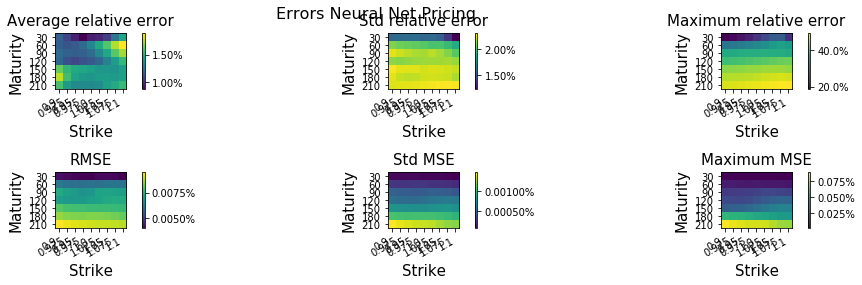

In [3]:
# Training of CNN
NN1 = Sequential() 
NN1.add(InputLayer(input_shape=(Nparameters,1,1,)))
NN1.add(ZeroPadding2D(padding=(2, 2)))
NN1.add(Conv2D(32, (3, 1), padding='valid',use_bias =True,strides =(1,1),activation='elu'))#X_train_trafo.shape[1:],activation='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(1,1),activation ='elu'))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (3,3),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
NN1.add(ZeroPadding2D(padding=(1,1)))
NN1.add(Conv2D(32, (2, 2),padding='valid',use_bias =True,strides =(2,1),activation ='elu'))
#NN1.add(MaxPooling2D(pool_size=(2, 1)))
#NN1.add(Dropout(0.25))
#NN1.add(ZeroPadding2D(padding=(0,1)))
NN1.add(Conv2D(Nstrikes, (2, 1),padding='valid',use_bias =True,strides =(2,1),activation ='linear', kernel_constraint = tf.keras.constraints.NonNeg()))
#NN1.add(MaxPooling2D(pool_size=(4, 1)))
NN1.summary()
#NN1.compile(loss = "MSE", optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN1.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])
#NN1.fit(X_train_trafo, y_train_trafo, batch_size=64, validation_data = (X_val_trafo, y_val_trafo),
#        epochs = 300, verbose = True, shuffle=1)
#NN1.save_weights("pricerweights_noh0.h5")
NN1.load_weights("pricerweights_noh0.h5")



# ### 2.1 Results 
# The following plots show the performance on the testing set

S0=1.
y_test_re    = yinversetransform(y_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))
prediction   = NN1.predict(X_test_trafo).reshape((Ntest,Nmaturities,Nstrikes))

#plots
err_rel_mat,err_mat,idx,bad_idx = pricing_plotter(prediction,y_test_re)

# 3. CNN as  Decoder/Inverse Mapping / Calibration

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 5, 7, 64)          640       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 6, 64)          16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 3, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 2, 64)          16448     
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 3, 4, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 3, 64)          16448     
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 4, 5, 64)         

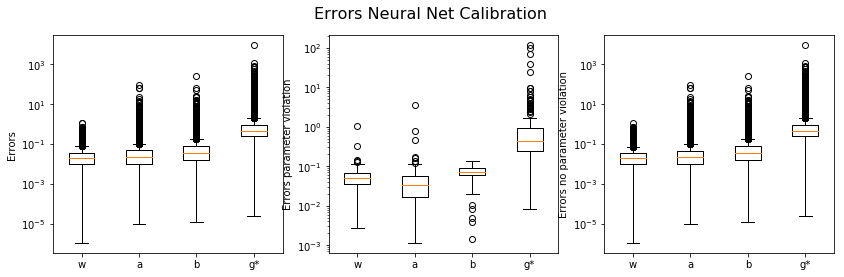

violation error mean in %: [  5.98927776   6.8221351    7.42543897 316.35085763]
no violation error mean in %: [  2.9924243   12.13138926  18.85546468 450.31256967]
violation error median in %: [ 5.03271975  3.38136608  7.19288749 44.51284495]
no violation error median in %: [ 1.97899821  2.12653456  3.39140995 42.10112391]
error mean in %: [  3.05715633  12.01670937  18.60857613 447.41899669]
error median in %: [ 2.01685614  2.1496453   3.51265672 42.12497992]


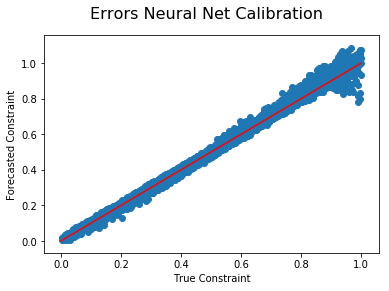

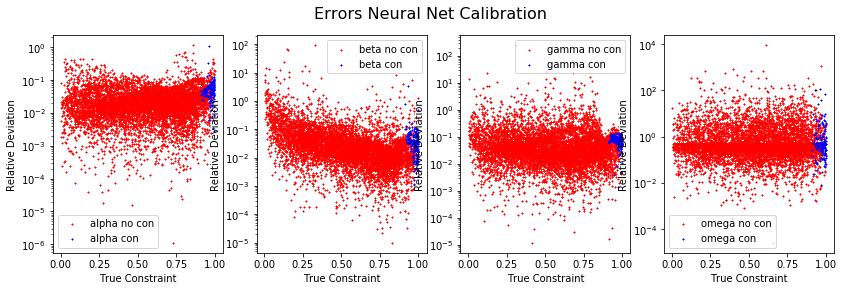

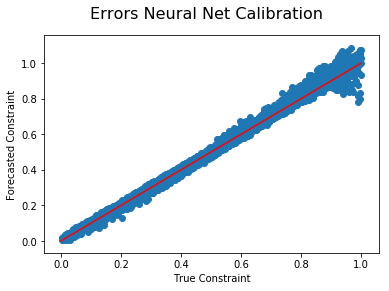

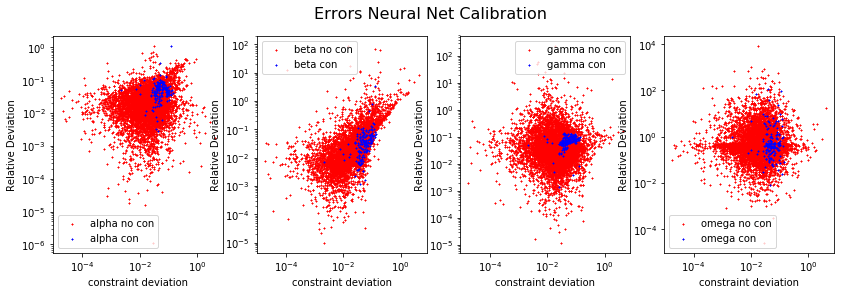

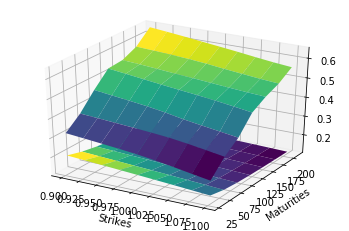

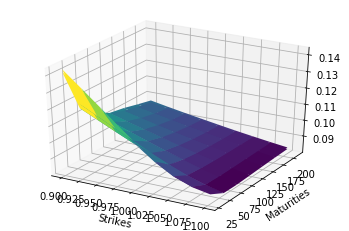

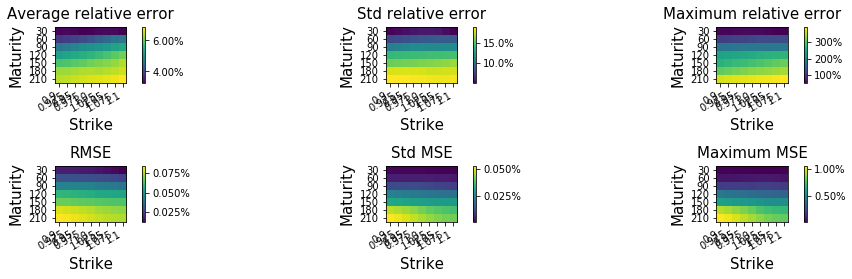

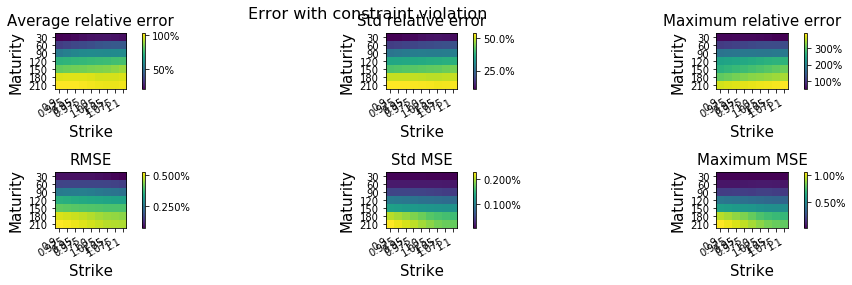

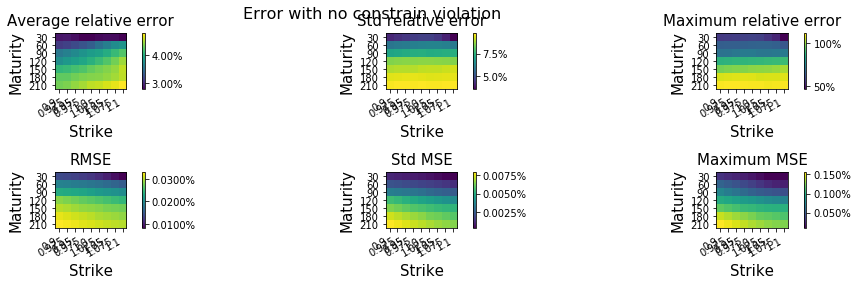

In [4]:
NN2 = Sequential() 
NN2.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2.add(Conv2D(64,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(MaxPooling2D(pool_size=(2, 2)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(ZeroPadding2D(padding=(1,1)))
NN2.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='tanh'))
NN2.add(Flatten())
NN2.add(Dense(Nparameters,activation = 'linear',use_bias=True))
NN2.summary()
#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN2.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#    epochs=300, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights_noh0.h5")
NN2.load_weights("calibrationweights_noh0.h5")


# ### 3.1 Results

from add_func_noh0 import calibration_plotter
prediction_calibration = NN2.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)


# ### 3.2 Testing the performace of the AutoEncoder/Decoder Combination
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.

forecast = autoencoder(NN1,NN2)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)



# 4 CNN as  Decoder/Inverse Mapping / Calibration TANHELU


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 5, 7, 12)          120       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 4, 6, 24)          1176      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 3, 24)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 2, 32)          3104      
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 3, 4, 32)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 2, 3, 32)          4128      
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 4, 5, 32)         

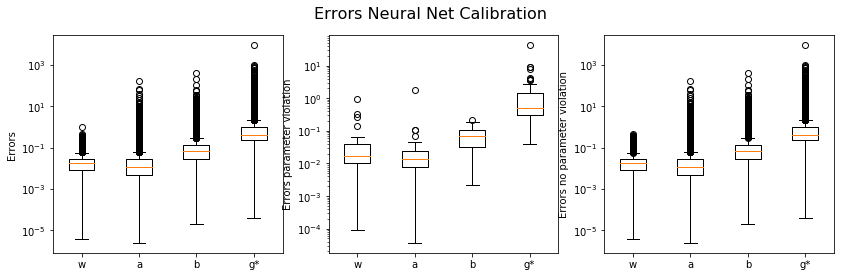

violation error mean in %: [  5.65450035   5.80065936   7.19787927 234.00511325]
no violation error mean in %: [  2.41377306  14.716006    34.88775379 459.50181417]
violation error median in %: [ 1.69245101  1.41527179  6.8381921  50.25173297]
no violation error median in %: [ 1.69399999  1.09276361  6.61976858 41.34068868]
error mean in %: [  2.43408162  14.66013649  34.71423058 458.08870151]
error median in %: [ 1.69364472  1.09552153  6.62007188 41.37252668]


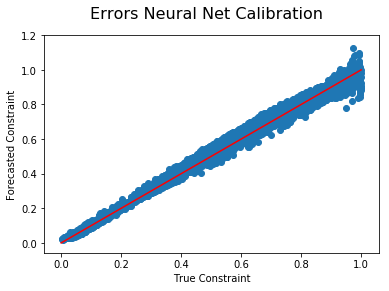

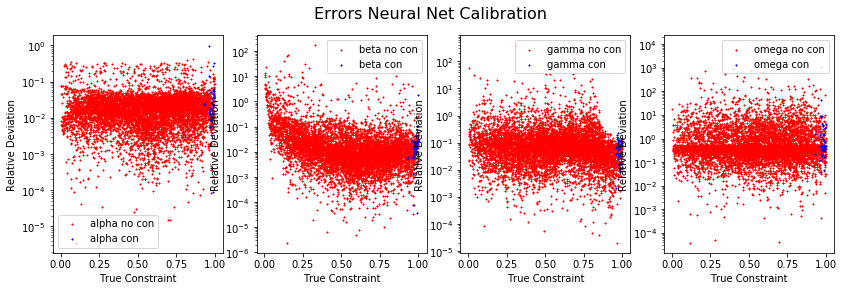

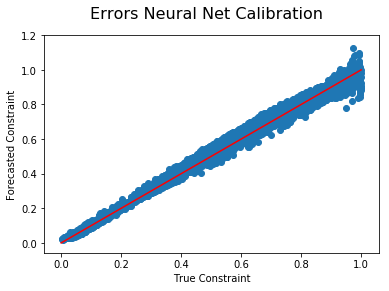

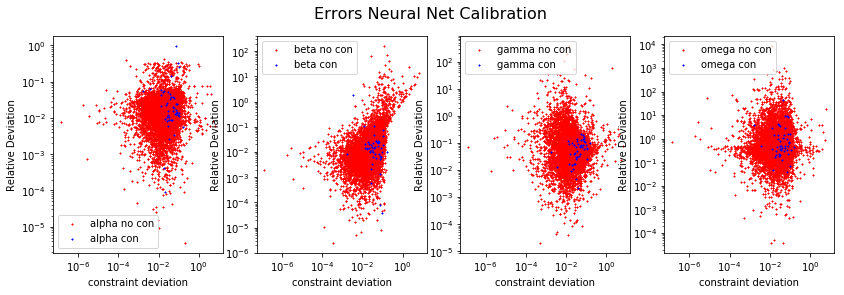

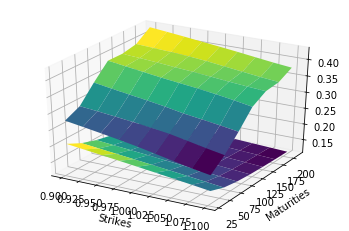

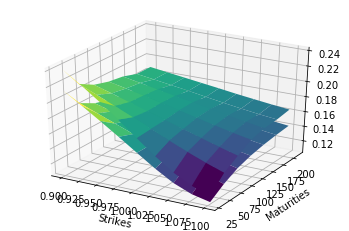

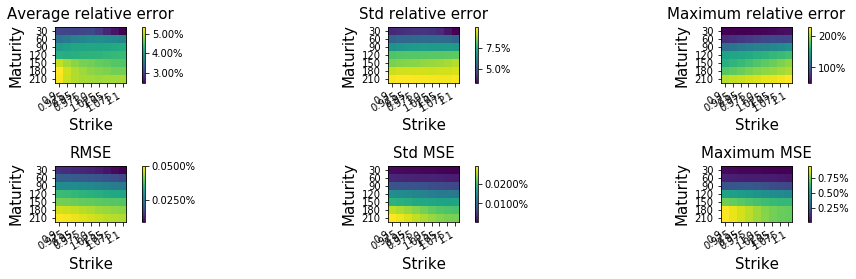

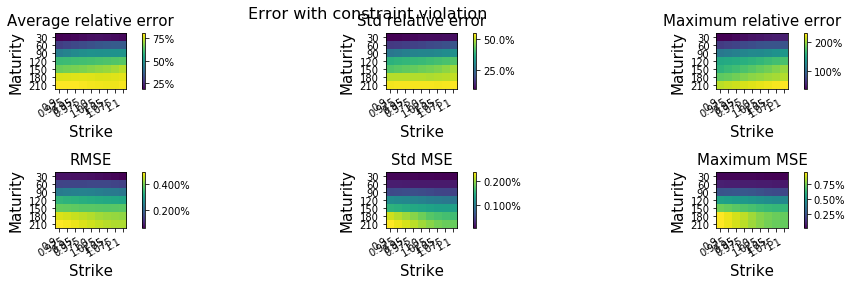

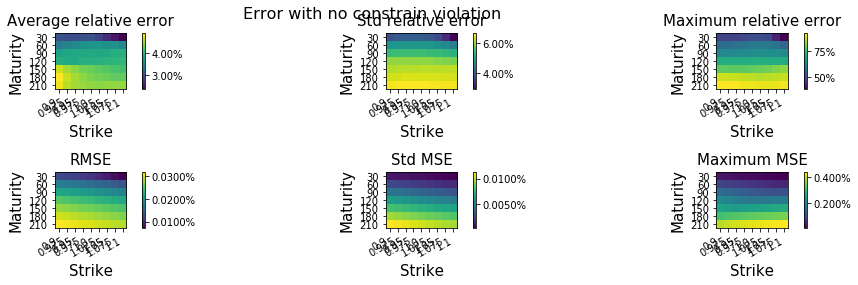

In [7]:
NN2c = Sequential() 
NN2c.add(InputLayer(input_shape=(Nmaturities,Nstrikes,1)))
NN2c.add(Conv2D(12,(3, 3),use_bias= True, padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(24,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(MaxPooling2D(pool_size=(2, 2)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(32,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(ZeroPadding2D(padding=(1,1)))
NN2c.add(Conv2D(64,(2, 2),use_bias= True,padding='valid',strides =(1,1),activation ='elu'))
NN2c.add(Flatten())
NN2c.add(Dense(Nparameters,activation = "tanh", kernel_constraint = tf.keras.constraints.NonNeg(),use_bias=True))
NN2c.summary()

#NN2.compile(loss = root_relative_mean_squared_error, optimizer = "adam",metrics=["MAPE","MSE"])

#setting
#NN2c.compile(loss =mse_constraint(0.25), optimizer = "adam",metrics=["MAPE", "MSE"])
#history = NN2c.fit(y_train_trafo2,X_train_trafo2, batch_size=50, validation_data = (y_val_trafo2,X_val_trafo2),
#    epochs=300, verbose = True, shuffle=1)
#NN2.save_weights("calibrationweights_elutanh_noh0.h5")
NN2c.load_weights("calibrationweights_elutanh_noh0.h5")


# ### 5.1 Results

# In[10]:



from add_func_noh0 import calibration_plotter
prediction_calibration = NN2c.predict(y_test_trafo2)
prediction_invtrafo= np.array([myinverse(x) for x in prediction_calibration])

#plots
error,err1,err2,vio_error,vio_error2,c,c2,testing_violation,testing_violation2 = calibration_plotter(prediction_calibration,X_test_trafo2,X_test)

# In[Testing the performace of the AutoEncoder/Decoder Combination]
# We test how the two previously trained NN work together. First, HNG-Vola surfaces are used to predict the underlying parameters with NN2. Those predictions are fed into NN1 to get Vola-Surface again. The results are shown below.


forecast = autoencoder(NN1,NN2c)(y_test_trafo2)
#prediction = NN2.predict(y_test_trafo2)
#prediction_trafo = prediction.reshape((Ntest,Nparameters,1,1))
#forecast = NN1.predict(prediction_trafo).reshape(Ntest,Nmaturities,Nstrikes)
y_true_test = y_test_trafo2.reshape(Ntest,Nmaturities,Nstrikes)
mape_autoencoder,mse_autoencoder = plotter_autoencoder(forecast,y_true_test,y_test,testing_violation,testing_violation2)

